## ARIMA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Preparing Dataset

In [2]:
df = pd.read_csv("/content/weathern.csv")

In [3]:
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [4]:
df.head()

,DATE,PRCP,TMAX,TMIN
0,2010-08-01,0.01,81,65
1,2010-08-02,0.04,82,69
2,2010-08-03,0.00,84,72
3,2010-08-04,0.00,93,73
4,2010-08-05,1.03,95,70


In [9]:
#Converting Dataframe into series
series_tm = pd.Series(df['TMAX'].values, index = df['DATE'])

In [10]:
series_tm.head()

DATE
2010-08-01    81
2010-08-02    82
2010-08-03    84
2010-08-04    93
2010-08-05    95
dtype: int64

### Maximum temperature over the years

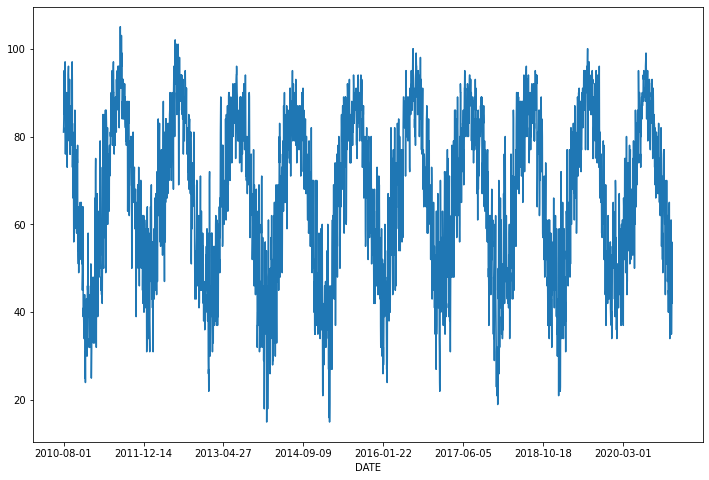

In [ ]:
series_tm.plot()
plt.gcf().set_size_inches(12,8)
plt.show()

### Autocorrelation

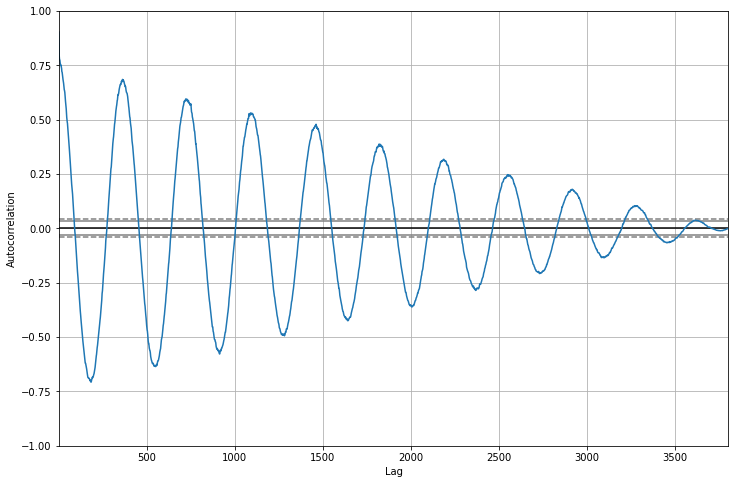

In [ ]:
from pandas.plotting import autocorrelation_plot

plt.gcf().set_size_inches(12,8)
autocorrelation_plot(series_tm)

In [ ]:
dfr = df[['DATE','TMAX']].copy()

In [ ]:
dfr.set_index('DATE', inplace=True)

In [ ]:
dfr_sample =  dfr.head(365)

### Rolling Statistics

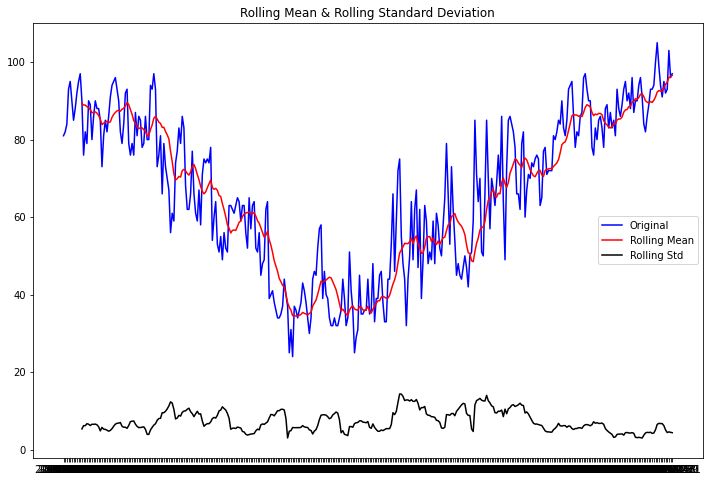

In [ ]:
rolling_mean = dfr_sample.rolling(window = 12).mean()
rolling_std = dfr_sample.rolling(window = 12).std()

plt.plot(dfr_sample, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.gcf().set_size_inches(12,8)
plt.show()

### Model Summary

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 3805
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -13058.692
Method:                       css-mle   S.D. of innovations              7.486
Date:                Mon, 16 Aug 2021   AIC                          26131.384
Time:                        19:03:02   BIC                          26175.093
Sample:                    08-02-2010   HQIC                         26146.917
                         - 12-31-2020                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0097      0.058     -0.168      0.867      -0.123       0.103
ar.L1.D.y     -0.2316      0.016    -14.449      0.000      -0.263      -0.200
ar.L2.D.y     -0.3187      0.016    -19.605      0.0

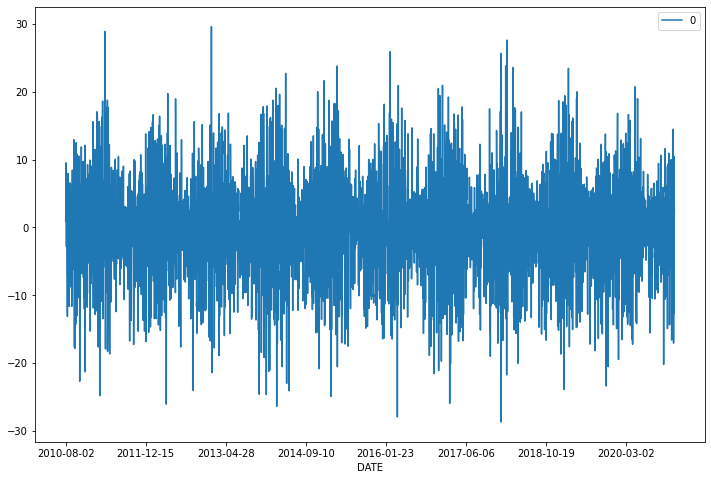

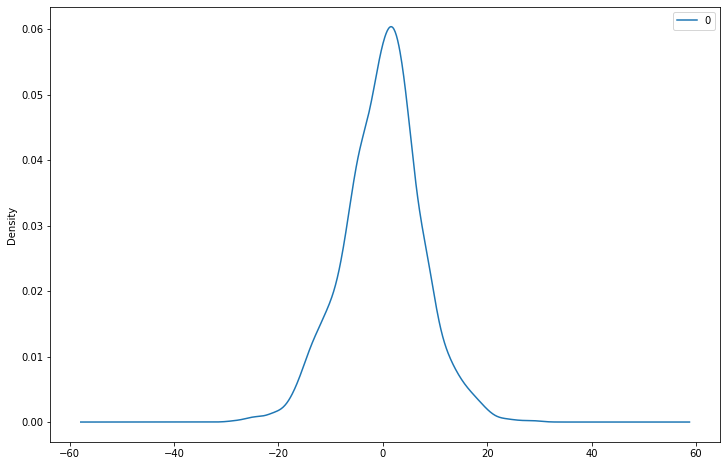

                 0
count  3805.000000
mean      0.001678
std       7.486794
min     -28.696187
25%      -4.630727
50%       0.416036
75%       4.569905
max      29.615018


In [ ]:
#created ARIMA model with parameters as 5,1,0

model = ARIMA(series_tm, order=(5,1,0))
model_fit = model.fit()
print(model_fit.summary())

residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.gcf().set_size_inches(12,8)
plt.show()

residuals.plot(kind='kde')
plt.gcf().set_size_inches(12,8)
plt.show()

print(residuals.describe())

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# split into train and test sets
X = series_tm.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.gcf().set_size_inches(12,9)
plt.show()

In [ ]:
#Error metric
from sklearn.metrics import r2_score

r2 = r2_score(test, predictions)

print('r2 score for ARIMA is:',r2)

r2 score for ARIMA is: 0.8370647483319289


## SARIMAX

In [7]:
#defining the parameter function

from statsmodels.tsa.statespace.sarimax import SARIMAX


def optimize_ARIMA(order_list, exog):
    """
        Return dataframe with parameters and corresponding AIC
        
        order_list - list with (p, d, q) tuples
        exog - the exogenous variable
    """
    
    results = []
    
    for order in tqdm_notebook(order_list):
        #try: 
        model = SARIMAX(exog, order=order).fit(disp=-1)
    #except:
    #        continue
            
        aic = model.aic
        results.append([order, model.aic])
    #print(results)
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [ ]:
import itertools
from tqdm import tqdm_notebook

ps = range(0, 10, 1)
d = 0
qs = range(0, 10, 1)

# Create a list with all possible combination of parameters
parameters = itertools.product(ps, qs)
parameters_list = list(parameters)

order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, d)
    each = tuple(each)
    order_list.append(each)
    
result_d_0 = optimize_ARIMA(order_list, exog = series_tm)

In [ ]:
result_d_0.head()

,"(p, d, q)",AIC
0,"(4, 0, 8)",25990.146712
1,"(5, 0, 8)",25990.768736
2,"(6, 0, 3)",25997.564213
3,"(5, 0, 4)",25998.233295
4,"(4, 0, 5)",25999.173587


In [ ]:
ps = range(0, 10, 1)
d = 1
qs = range(0, 10, 1)

# Create a list with all possible combination of parameters
parameters = itertools.product(ps, qs)
parameters_list = list(parameters)

order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, d)
    each = tuple(each)
    order_list.append(each)
    
result_d_1 = optimize_ARIMA(order_list, exog = series_tm)

result_d_1

In [ ]:
result_d_1.head()

,"(p, d, q)",AIC
0,"(1, 1, 6)",25950.915507
1,"(6, 1, 8)",25954.014212
2,"(5, 1, 7)",25955.683753
3,"(3, 1, 8)",25959.936208
4,"(3, 1, 7)",25961.725349


In [ ]:
final_result = result_d_0.append(result_d_1)
best_models = final_result.sort_values(by='AIC' , ascending=True).reset_index(drop=True).head()

In [ ]:
best_models.head()

,"(p, d, q)",AIC
0,"(1, 1, 6)",25950.915507
1,"(6, 1, 8)",25954.014212
2,"(5, 1, 7)",25955.683753
3,"(3, 1, 8)",25959.936208
4,"(3, 1, 7)",25961.725349


In [ ]:
best_model_params_0 = best_models[best_models.columns[0]][0]
best_model_params_1 = best_models[best_models.columns[0]][1]

In [ ]:
best_model_0 = SARIMAX(history, order=best_model_params_0).fit()
print(best_model_0.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 3806
Model:               SARIMAX(1, 1, 6)   Log Likelihood              -12967.458
Date:                Mon, 16 Aug 2021   AIC                          25950.916
Time:                        19:28:59   BIC                          26000.868
Sample:                             0   HQIC                         25968.667
                               - 3806                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9826      0.006    151.199      0.000       0.970       0.995
ma.L1         -1.2725      0.016    -81.618      0.000      -1.303      -1.242
ma.L2         -0.0277      0.023     -1.182      0.2

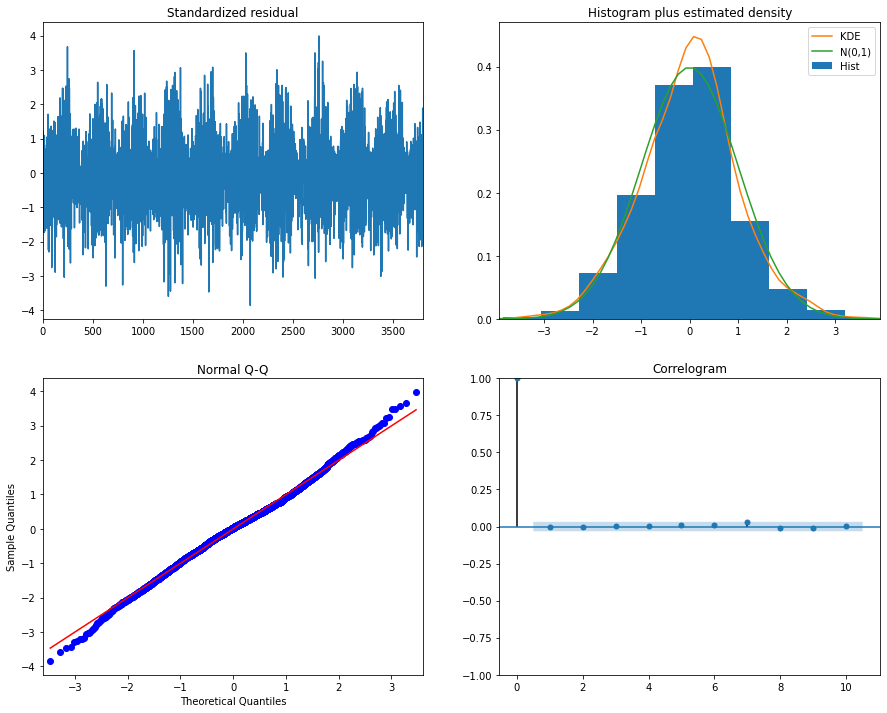

In [ ]:
best_model_0.plot_diagnostics(figsize=(15,12))
plt.show()

In [ ]:
#using the best model parameters with the lowest AIC

X = series_tm.values
size = int(len(X) * 0.66)
train_ar, test_ar = X[0:size], X[size:len(X)]
history_ar = [x for x in train_ar]
predictions_ar = list()
# walk-forward validation
for t in range(len(test_ar)):
  best_model_0 = SARIMAX(history_ar, order=best_model_params_0).fit()
  output_ar = best_model_0.forecast()
  yhat_ar = output_ar[0]
  predictions_ar.append(yhat_ar)
  obs_ar = test_ar[t]
  history_ar.append(obs_ar)
  print('predicted=%f, expected=%f' % (yhat_ar, obs_ar))

In [ ]:
#root mean square error

rmse = sqrt(mean_squared_error(test_ar, predictions_ar))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against expected
plt.plot(test_ar)
plt.plot(predictions_ar, color='red')
plt.gcf().set_size_inches(12,9)
plt.show()

In [ ]:
best_model_1 = SARIMAX(series_tm, order=best_model_params_1).fit()
print(best_model_1.summary())

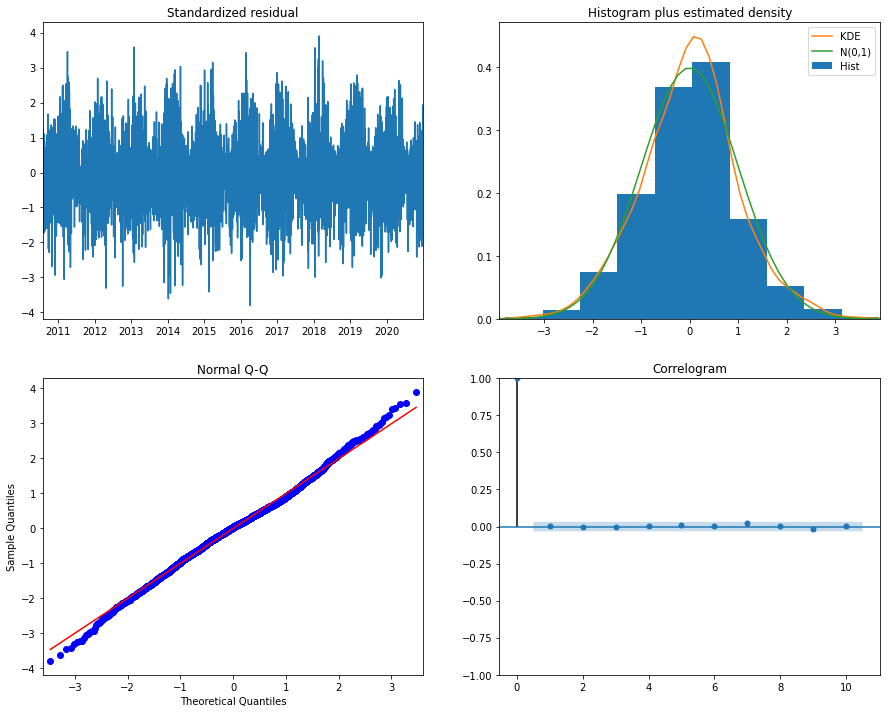

In [ ]:
best_model_1.plot_diagnostics(figsize=(15,12))
plt.show()

In [ ]:
#generating different combination of parameters

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('SARIMA parameter examples')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

SARIMA parameter examples
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [ ]:
parameters_lst = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
          mod = SARIMAX(series_tm,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
          results = mod.fit()
          parameters_lst.append('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))

In [5]:
my_order = (1,1,1)
seasonal_order = (1,1,1,12)

In [11]:
best_model_1 = SARIMAX(series_tm, order=my_order, seasonal_order = seasonal_order).fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [15]:
print(best_model_1.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                 3806
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood              -13015.693
Date:                            Thu, 19 Aug 2021   AIC                          26041.386
Time:                                    12:14:09   BIC                          26072.590
Sample:                                08-01-2010   HQIC                         26052.477
                                     - 12-31-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5494      0.018     29.830      0.000       0.513       0.585
ma.L1         -0.8953      0.010   

In [ ]:
X = series_tm.values
size = int(len(X) * 0.66)
train_sr1, test_sr1 = X[0:size], X[size:len(X)]
history_sr1 = [x for x in train_sr1]
predictions_sr1 = list()
# walk-forward validation
for t in range(len(test_sr1)):
  best_model_1 = SARIMAX(history_sr1, order=my_order, seasonal_order = seasonal_order).fit()
  output_sr1 = best_model_1.forecast()
  yhat_sr1 = output_sr1[0]
  predictions_sr1.append(yhat_sr1)
  obs_sr1 = test_sr1[t]
  history_sr1.append(obs_sr1)
  print('predicted=%f, expected=%f' % (yhat_sr1, obs_sr1))

predicted=83.685423, expected=80.000000
predicted=80.536300, expected=86.000000
predicted=84.442070, expected=91.000000
predicted=87.880030, expected=87.000000
predicted=85.058955, expected=86.000000
predicted=85.686384, expected=88.000000
predicted=87.922671, expected=86.000000
predicted=84.926035, expected=87.000000
predicted=86.295216, expected=86.000000
predicted=86.014300, expected=85.000000
predicted=86.287759, expected=81.000000
predicted=82.319216, expected=80.000000
predicted=81.016130, expected=80.000000
predicted=81.196705, expected=89.000000
predicted=86.912074, expected=92.000000
predicted=89.088782, expected=91.000000
predicted=88.132106, expected=90.000000
predicted=88.870068, expected=90.000000
predicted=89.778646, expected=90.000000
predicted=88.150626, expected=84.000000
predicted=84.995966, expected=80.000000
predicted=82.521536, expected=88.000000
predicted=88.467042, expected=87.000000
predicted=86.599782, expected=83.000000
predicted=83.537258, expected=89.000000


In [ ]:
r2 = r2_score(test_sr1, predictions_sr1)

print('r2 score for SARIMAX2 is:',r2)

In [ ]:
rmse = sqrt(mean_squared_error(test_sr1, predictions_sr1))